In [1]:
# Import custom module
import sys
import os
sys.path.insert(0,os.path.abspath("../scripts"))
import prediction as pre
import importlib
importlib.reload(pre)

import logging
import pandas as pd


In [2]:
# Load a small sample to inspect data
train_sample = pd.read_csv('../data/train.csv', nrows=10)

# Check the data types
print(train_sample.dtypes)

# Inspect values in column 7 (replace with actual column index or name)
print(train_sample.iloc[:, 7].unique())

# Load the full dataset with the correct dtype for column 7
train = pd.read_csv('../data/train.csv', dtype={'StateHoliday': 'str'})  # Treat 'StateHoliday' as string


Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday      int64
SchoolHoliday     int64
dtype: object
[0]


In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', filename='../logs/rossmann_sales_forecast.log')
# Load the dataset
test = pre.load_data('../data/test.csv')

Pre-processing data

In [4]:
#  Apply feature engineering
train = pre.feature_engineering(train)
test = pre.feature_engineering(test)

In [5]:
# Handle missing values
train = pre.handle_missing(train)
test = pre.handle_missing(test)

In [6]:
# Prepare features and target
X_train = train.drop(columns=['Sales', 'Customers', 'Date', 'Store'])
y_train = train['Sales']
X_test = test.drop(columns=['Date', 'Store'])

In [7]:
# Encode categorical variables
X_train_encoded, X_test_encoded = pre.encode_categorical(X_train, X_test)

Building models with sklearn pipelines

In [8]:
# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = pre.train_test_split(X_train_encoded, y_train, test_size=0.2, random_state=42)

In [9]:
# Train the model
model = pre.train_model(X_train_split, y_train_split)

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [10]:
# Evaluate the model
pre.evaluate_model(model, X_val_split, y_val_split)

RMSE: 2444.1386896772933


In [11]:
test['PredictedSales'] = model.predict(X_test_encoded)

In [12]:
# Save predictions to a CSV file
test[['Id', 'PredictedSales']].to_csv('../data/predicted_sales.csv', index=False)
print("Predictions saved.")

Predictions saved.


Choose a loss function

Root Mean Squared Error (RMSE):

RMSE gives higher weight to large errors, making it suitable for cases where outliers or large deviations matter. Since you're predicting sales, having a few large errors could be detrimental to business planning, so RMSE is often a good choice.
Pros: Sensitive to large errors (e.g., over-predicting sales for a store by a large margin).
Cons: May overly penalize outliers.

In [13]:
# Make predictions for the validation set
y_pred = model.predict(X_val_split)
pre.calculate_rmse(y_val_split, y_pred)

RMSE: 2444.1386896772933


Post-Prediction Analysis

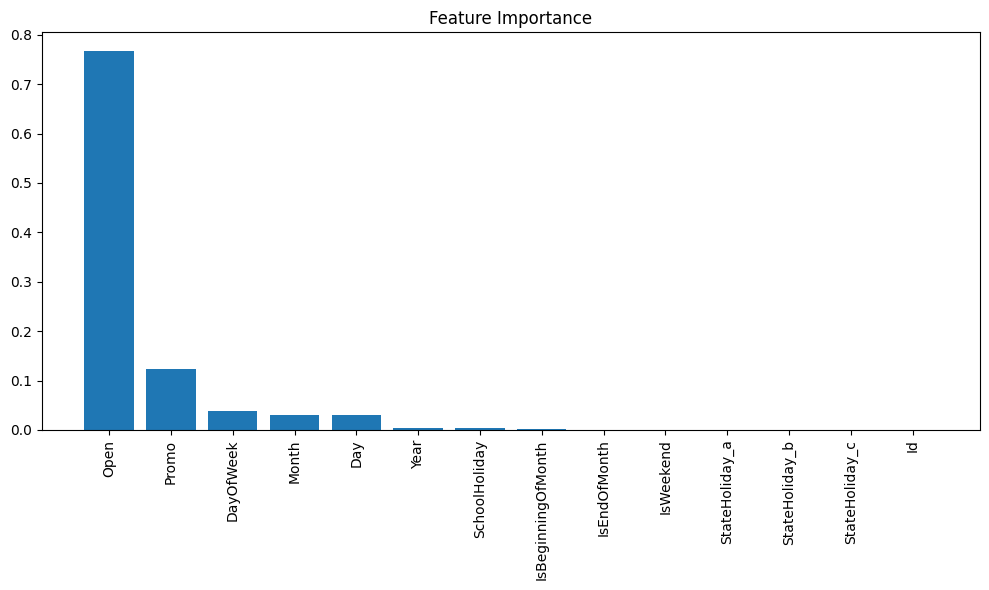

In [14]:
pre.plot_feature_importance(model, X_train_encoded)

Confidence Interval Estimation

In [15]:
# Downsample the training data to 10% of the original size for faster processing
train_sampled = train.sample(frac=0.1, random_state=42)
X_train_sampled = X_train_encoded.sample(frac=0.1, random_state=42)
y_train_sampled = y_train.sample(frac=0.1, random_state=42)

# Set the number of bootstrap iterations and the number of jobs for parallel processing
n_iterations = 10  # Start with fewer iterations
n_jobs = -1  # Use all available CPU cores
alpha = 0.95  # 95% confidence interval


# Call the bootstrap confidence interval function with parallel processing
lower_bound, upper_bound = pre.estimate_confidence_intervals(X_train_sampled, y_train_sampled, X_test_encoded, n_iterations, alpha, n_jobs)

# Print a few sample results
print("Sample predictions with confidence intervals:")
for i in range(5):  # Display only the first 5 samples
    print(f"Predicted Sales: {test['PredictedSales'][i]:.2f}, "
          f"95% CI: [{lower_bound[i]:.2f}, {upper_bound[i]:.2f}]")


Lower bound: [6804.80015672 6804.80015672 6804.80015672 ... 5935.09134605 5935.09134605
 5602.12086897]
Upper bound: [7184.18823266 7184.18823266 7184.18823266 ... 7517.03454334 7517.03454334
 7484.765791  ]
Sample predictions with confidence intervals:
Predicted Sales: 7013.80, 95% CI: [6804.80, 7184.19]
Predicted Sales: 7013.80, 95% CI: [6804.80, 7184.19]
Predicted Sales: 7013.80, 95% CI: [6804.80, 7184.19]
Predicted Sales: 7013.80, 95% CI: [6804.80, 7184.19]
Predicted Sales: 7013.80, 95% CI: [6804.80, 7184.19]


Serialize models

In [16]:
pre.serialize_model(model)

Model saved as ../models/sales_model_24-09-2024-23-02-39.pkl
